## Teoría
**Defina y responda**
1. Comparar la simulación de tiempo discreto (síncrona) y de tiempo continuo (asíncrona):
    - Describir escenarios donde cada una es preferible.
    
    ***Tiempo Discreto (Síncrono):***
    Este puede ser utilizado para hacer análisis en salud por ejemplo el ver medidas que se implementan diariamente (como restricciones, vacunaciones). O bien en sistemas con actualizaciones naturalmente periódicas como funcioanan los hospitales que reportan datos diariamente, turnos de personal

    ***Tiempo Continuo (Asíncrono):***

    Esta puede ser utilizada para estudios detallados de transmisión, como el análisis preciso de cómo y cuándo ocurren las infecciones o bien evaluaciones de medidas de control en tiempo real. 
  
    - Analizar las compensaciones computacionales (velocidad vs. precisión).

    | Aspecto              | Tiempo Discreto (Síncrono)                | Tiempo Continuo (Asíncrono)                |
    |----------------------|--------------------------------------------|---------------------------------------------|
    | **Velocidad**        | Más rápido para simulaciones largas      | Más lento por overhead de eventos        |
    | **Precisión Temporal** | Limitada al tamaño del paso           | Alta precisión en el timing de eventos   |
    | **Memoria**          | Hace menor uso de memoria                    | Mayor uso por gestión de cola de eventos |
    | **Paralelización**   | Es más fácil de paralelizar                    | Es más complejo de paralelizar             |
    | **Determinismo**     | reproducible con misma semilla          | Sensible al orden de eventos            |

    En general el tiempo discreto es preferible cuando se prioriza la velocidad y la simplicidad, especialmente en sistemas donde los eventos ocurren a intervalos regulares y la precisión temporal no es crítica. Ahora bien, el tiempo continuo es ideal cuando se requiere alta precisión en el momento exacto de los eventos, aunque esto implica mayor complejidad computacional y de memoria.

2. Sobre los mecanismos de gestión de eventos:
    
**a) ¿Cómo las colas de eventos gestionan los cambios de estado?**
    
 En simulaciones de eventos discretos (tiempo continuo), se utiliza una cola de prioridad (generalmente implementada como un heap) para almacenar los eventos futuros ordenados por su timestamp (momento de ocurrencia). En donde el evento con el timestamp más bajo se procesa primero, garantizando la consistencia temporal y que los cambios de estado ocurran en el orden correcto.Cuando se procesa un evento, este puede generar nuevos eventos que se insertan en la cola manteniendo el orden. La inserción y extracción en la cola de prioridad es eficiente (O(log n)), permitiendo escalar a simulaciones con muchos eventos. Si dos o más eventos tienen el mismo timestamp, se aplican reglas de desempate para asegurar reproducibilidad y coherencia.

**b) Gestión de prioridades para eventos concurrentes:**
 Cuando varios eventos ocurren exactamente al mismo tiempo, es fundamental definir una jerarquía de prioridades para evitar ambigüedades en el estado del sistema.
 Un ejemplo típico de jerarquía de prioridades en simulaciones epidemiológicas podría ser:

1. Eventos de muerte (máxima prioridad, ya que afectan la existencia del agente)

2. Eventos de recuperación

3. Eventos de infección

4. Eventos de movimiento

5. Eventos de contacto (menor prioridad)

En donde (en este caso) jerarquía asegura que un agente que muere no pueda infectar ni moverse después de su muerte, manteniendo la lógica y consistencia del modelo. Donde la gestión adecuada de prioridades es clave para evitar resultados inconsistentes y garantizar la reproducibilidad de la simulación.

## Ejercicio práctico
**Diseñe un marco de simulación de Python:**
1. Escenario: Propagación de enfermedades en un hospital
2. Tareas
    - Esboce dos arquitecturas:
        
### A) Arquitectura de Tiempo Discreto (actualizaciones diarias)
- **Descripción:** El sistema avanza en pasos de tiempo fijos (por ejemplo, días). En cada paso, se actualizan los estados de todos los agentes según reglas predefinidas.
- **Atributos clave del agente:**
    - estado_salud: susceptible, infectado, recuperado, fallecido
    - dias_infectado: contador de días desde la infección
    - vacunado: True/False
    - edad, ocupacion, esquema_vacunacion
- **Tipos de eventos a monitorizar:**
    - Nuevas infecciones
    - Recuperaciones
    - Fallecimientos
    - Vacunaciones
- **Métricas de salida esperadas:**
    - Número diario de infectados, recuperados y fallecidos
    - R0 estimado
    - Porcentaje de población vacunada
- **Pseudocódigo:**
```python
for dia in range(dias_simulacion):
    for agente in poblacion:
        if agente.estado_salud == 'infectado':
            agente.dias_infectado += 1
            if agente.dias_infectado > periodo_recuperacion:
                agente.estado_salud = 'recuperado'
        # Probabilidad de infección a contactos
        # Actualizar métricas diarias
```

### B) Arquitectura de Tiempo Continuo (eventos impulsados)
- **Descripción:** El sistema avanza de un evento a otro (por ejemplo, infección, recuperación, muerte), cada uno con su propio timestamp.
- **Atributos clave del agente:**
    - estado_salud: susceptible, infectado, recuperado, fallecido
    - tiempo_siguiente_evento: timestamp del próximo evento
    - esquema_vacunacion, tasa_movilidad, prob_contacto
- **Tipos de eventos a monitorizar:**
    - Infección
    - Recuperación
    - Muerte
    - Contacto entre agentes
- **Métricas de salida esperadas:**
    - Tiempos exactos de cada evento
    - Distribución de intervalos entre eventos
    - Evolución temporal de la epidemia
- **Pseudocódigo:**
```python
while cola_eventos:
    evento = cola_eventos.pop()
    procesar(evento)
    # Insertar nuevos eventos generados en la cola
    # Actualizar métricas
```

### Ejemplo de definición de agente (válido para ambos modelos)
```python
from dataclasses import dataclass

@dataclass
class Agente:
    estado_salud: str            # susceptible, infectado, recuperado, fallecido
    dias_infectado: int = 0     # solo para tiempo discreto
    esquema_vacunacion: str     # ninguna, incompleta, completa, refuerzo
    tasa_movilidad: float = 0.0 # solo para tiempo continuo
    prob_contacto: float = 0.0  # solo para tiempo continuo
    comunidad_id: int = 0
```

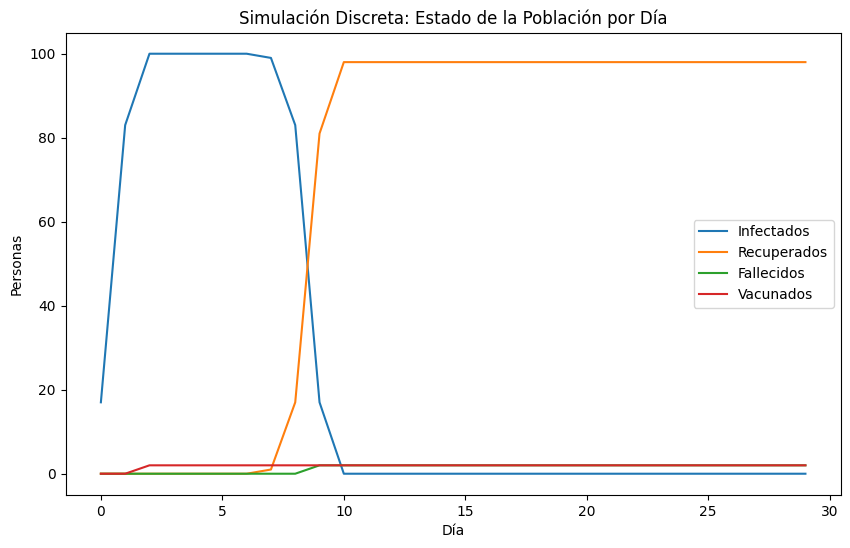

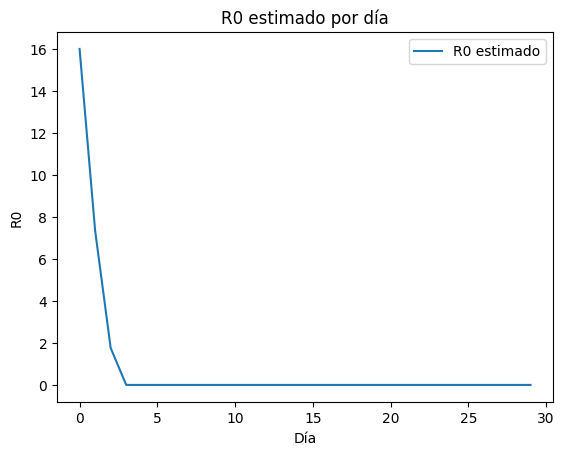

In [2]:
# Simulación de propagación de enfermedad en tiempo discreto (hospital)
from dataclasses import dataclass
import random
import matplotlib.pyplot as plt

# Definición del agente
@dataclass
class Agente:
    estado_salud: str            # susceptible, infectado, recuperado, fallecido
    dias_infectado: int = 0     # solo para tiempo discreto
    vacunado: bool = False
    edad: int = 0
    ocupacion: str = 'otro'     # doctor, enfermero, paciente, etc.
    esquema_vacunacion: str = 'ninguna' # ninguna, incompleta, completa, refuerzo
    comunidad_id: int = 0

# Parámetros de la simulación
N = 100
dias_simulacion = 30
prob_infeccion = 0.1
periodo_recuperacion = 7
prob_muerte = 0.02
prob_vacunacion = 0.01  # probabilidad diaria de vacunar a un susceptible

# Inicializar población
poblacion = [Agente('susceptible', edad=random.randint(20,70), ocupacion=random.choice(['doctor','enfermero','paciente','otro'])) for _ in range(N)]
poblacion[0].estado_salud = 'infectado'  # Paciente cero

infectados_hist = []
recuperados_hist = []
fallecidos_hist = []
vacunados_hist = []
r0_hist = []

for dia in range(dias_simulacion):
    nuevos_infectados = []
    nuevos_recuperados = 0
    nuevos_fallecidos = 0
    nuevos_vacunados = 0
    infecciones_este_dia = 0
    for agente in poblacion:
        if agente.estado_salud == 'infectado':
            agente.dias_infectado += 1
            # Intentar infectar a otros
            for otro in poblacion:
                if (otro.estado_salud == 'susceptible' and not otro.vacunado
                    and random.random() < prob_infeccion):
                    nuevos_infectados.append(otro)
                    infecciones_este_dia += 1
            # Recuperación o fallecimiento
            if agente.dias_infectado > periodo_recuperacion:
                if random.random() < prob_muerte:
                    agente.estado_salud = 'fallecido'
                    nuevos_fallecidos += 1
                else:
                    agente.estado_salud = 'recuperado'
                    nuevos_recuperados += 1
        # Vacunación diaria
        if (agente.estado_salud == 'susceptible' and not agente.vacunado
            and random.random() < prob_vacunacion):
            agente.vacunado = True
            agente.esquema_vacunacion = 'completa'
            nuevos_vacunados += 1
    for ni in nuevos_infectados:
        ni.estado_salud = 'infectado'
        ni.dias_infectado = 0
    infectados_hist.append(sum(a.estado_salud == 'infectado' for a in poblacion))
    recuperados_hist.append(sum(a.estado_salud == 'recuperado' for a in poblacion))
    fallecidos_hist.append(sum(a.estado_salud == 'fallecido' for a in poblacion))
    vacunados_hist.append(sum(a.vacunado for a in poblacion))
    # R0 estimado: infecciones nuevas / infectados actuales (evitar div/0)
    infectados_actuales = infectados_hist[-2] if dia > 0 else 1
    r0_hist.append(infecciones_este_dia / infectados_actuales if infectados_actuales else 0)

# Graficar resultados
plt.figure(figsize=(10,6))
plt.plot(infectados_hist, label='Infectados')
plt.plot(recuperados_hist, label='Recuperados')
plt.plot(fallecidos_hist, label='Fallecidos')
plt.plot(vacunados_hist, label='Vacunados')
plt.xlabel('Día')
plt.ylabel('Personas')
plt.title('Simulación Discreta: Estado de la Población por Día')
plt.legend()
plt.show()

plt.figure()
plt.plot(r0_hist, label='R0 estimado')
plt.xlabel('Día')
plt.ylabel('R0')
plt.title('R0 estimado por día')
plt.legend()
plt.show()

## **Prompt utilizado**
*Se utilizó ChatGPT para generar el código de la simulación*

**Prompt:**
Hola me puedes ayudar a completar con la realización de una simulación, estas son las intrucciones: Diseñe un marco de simulación de Python: Escenario: Propagación de enfermedades en un hospital. Tareas : Esboce dos arquitecturas: i. Tiempo discreto (actualizaciones diarias), ii. Tiempo continuo (infecciones impulsadas por eventos) Para cada una, programe i. Atributos clave del agente necesarios, ii. Tipos de eventos a monitorizar., iii. Métricas de salida esperadas. Por lo cuál tenia pensado la propagación de enfermedades en un hospital en donde el sistema avanza en pasos de tiempo fijos (por ejemplo, días). En cada paso, se actualizan los estados de todos los agentes según reglas predefinidas. como estado_salud: susceptible, infectado, recuperado, fallecido o bien  dias_infectado: contador de días desde la infección
- **Pseudocódigo:**
```python
for dia in range(dias_simulacion):
    for agente in poblacion:
        if agente.estado_salud == 'infectado':
            agente.dias_infectado += 1
            if agente.dias_infectado > periodo_recuperacion:
                agente.estado_salud = 'recuperado'
```
Ahora para la arquitectura de Tiempo Continuo (eventos impulsados), el sistema avanza de un evento a otro (por ejemplo, infección, recuperación, muerte), cada uno con su propio timestamp.
- **Pseudocódigo:**
```python
while cola_eventos:
    evento = cola_eventos.pop()
    procesar(evento)
    # Insertar nuevos eventos generados en la cola
    # Actualizar métricas
```
```python
from dataclasses import dataclass

@dataclass
class Agente:
    estado_salud: str            # susceptible, infectado, recuperado, fallecido
    dias_infectado: int = 0     # solo para tiempo discreto
    esquema_vacunacion: str     # ninguna, incompleta, completa, refuerzo
    tasa_movilidad: float = 0.0 # solo para tiempo continuo
    prob_contacto: float = 0.0  # solo para tiempo continuo
    comunidad_id: int = 0
```

### **Por qué funcionó este prompt**

 En este caso el prompt funcionó porque se especifica claramente el objetivo y el contexto de la simulación (propagación de enfermedades en un hospital) donde además detalla los requisitos para el diseño en donde pide dos arquitecturas (tiempo discreto y tiempo continuo), los atributos clave de los agentes, los tipos de eventos a monitorizar y las métricas de salida esperadas.

## Referencias

Rodríguez, I. C. (s/f). Continuo vs. discreto: Simulación de eventos discretos. Ull.Es.  https://enginedu.webs.ull.es/oa_des/continuo_vs_discreto_simulacin_de_eventos_discretos.html

Synchrony and time-step. (s/f). Readthedocs.io. https://carla.readthedocs.io/en/latest/adv_synchrony_timestep/

What Are Message Queues in Event-Driven Architecture? (s/f). Akamai.com. https://www.akamai.com/glossary/what-are-message-queues